# Task 3: Finetune ResNet
# CENG501 - Spring 2023 - PA2

In this task, we will practice transfer learning by adapting and finetuning ResNet18 (pretrained on ImageNet) for CIFAR10.


## 1 Import the Modules

Let us start by importing some libraries that we will use throughout the task.

In [1]:
import matplotlib.pyplot as plt # For plotting
import numpy as np              # NumPy, for working with arrays/tensors 
import time                     # For measuring time
import random                   # Python's random library

# PyTorch libraries:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# install and import the torchinfo library
!pip install torchinfo
from torchinfo import summary

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 1.1 Enable GPU

From "Edit -> Notebook Settings -> Hardware accelerator" select GPU. With the following we will specify to PyTorch that we want to use the GPU.

In [2]:
if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

Cuda (GPU support) is available and enabled!


## 2 Download and Test Pretrained ResNet18

We have talked about ResNet in detail in the lectures. We will take Pytorch's ResNet18 model (https://pytorch.org/hub/pytorch_vision_resnet/), which was trained on ImageNet, and adapt & finetune it for CIFAR10.

Here are a couple of critical information about ResNet18's input (from Pytorch document):

"All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]."

### 2.1 Download ResNet18

In [3]:
# Thanks to Pytorch datasets, this is very easy:

OrigResNet18 = None
###########################################################
# @TODO: Look at PyTorch's documentation for downloading  #
# and loading a pretrained ResNet18 model.                #
#                                                         #
# Hint: This should be a single function call.            #
###########################################################

OrigResNet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
###########################################################
#                         END OF YOUR CODE                #
###########################################################
print(OrigResNet18)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 219MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 2.2 Get ImageNet Labels

Before we finetune ResNet18, let us see what it predicts on CIFAR10. To be able to do so, we will require the list of ImageNet labels.

In [4]:
# Download ImageNet labels
!wget -nc https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

--2023-05-30 19:41:04--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2023-05-30 19:41:04 (81.1 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



### 2.3 Load CIFAR10

As we mentioned above, ResNet18 expects images with resolution 224x224 and normalized with a mean & std. Therefore, while loading CIFAR10, we will apply certain transformations to handle these requirements.

In [5]:
batch_size = 8

TF = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=TF)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=TF)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

CIFAR10_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:05<00:00, 28831236.74it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 2.4 Apply Pre-trained ResNet18 on CIFAR10

Let us look at what ResNet18 predicts on a batch of CIFAR10. For a set of samples, we will visualize the images and look at ResNet18's top predictions.

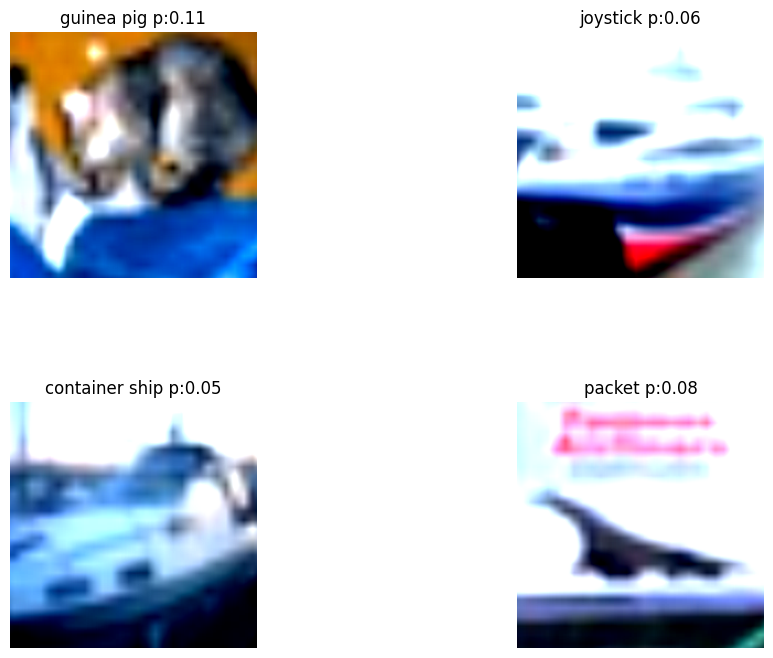

In [6]:
# Get a batch
dataiter = iter(testloader)
images, labels = next(dataiter)

# Get scores for classes on the batch
with torch.no_grad():
    output = OrigResNet18(images)

# Convert them to probabilities (shape: batch_size x 1000)
probabilities = torch.nn.functional.softmax(output, dim=1)

# Show results on a 2x2 grid
S=2
for i in range(S):
  for j in range(S):
    X = images[i*S+j]
    X = np.transpose((X.numpy()/2+0.5), (1, 2, 0))
    top1_prob, top1_catid = torch.topk(probabilities[i*S+j], 1)
    title = "{} p:{:1.2f}".format(categories[top1_catid], top1_prob.item())

    plt.subplot(S, S, i*S+j+1)
    plt.imshow(X)
    plt.axis('off')
    plt.title(title)
    plt.subplots_adjust(hspace = 0.5)


We see that the predictions are way off and we will hopefully get better results with some finetuning.

## 3 Adapt ResNet18 for CIFAR10

We will "freeze" the parameters of ResNet18 and replace the last layer of ResNet18 with a new layer which we will finetune.

In [7]:
# Copy ResNet18
import copy 
NewResNet18 = copy.deepcopy(OrigResNet18)

### 3.1 Freeze Parameters of ResNet18

We "freeze" a parameter by setting its `requires_grad` member variable to `False`.

In [8]:
###########################################################
# @TODO: Go over the parameters of NewResNet18 and set    #
# requires_grad for all parameters to False.              #
#                                                         #
# Hint: Check parameters() member function of NewResNet18.#
###########################################################

for parameter in NewResNet18.parameters():
    parameter.requires_grad = False

###########################################################
#                         END OF YOUR CODE                #
###########################################################

### 3.2 Add a New Learnable FC Layer to ResNet18

If you look at the summary of ResNet18 shown above, you will see that the last layer is:

  `(fc): Linear(in_features=512, out_features=1000, bias=True)`

In our case, we should just replace this with a new FC layer (its dimensions should be straight-forward to figure out).

In [9]:
NewResNet18.fc = None
###########################################################
# @TODO: Create a new layer and save it into              #
# NewResNet18.fc. This new layer will map the activations #
# of the previous layer to the outputs for the CIFAR10    #
# classes.                                                #
###########################################################

new_fc = nn.Linear(512, 10)
NewResNet18.fc = new_fc
###########################################################
#                         END OF YOUR CODE                #
###########################################################

### 3.3 Visualize the Model

Now, let us see whether the new fc layer is correct for CIFAR10.

In [10]:
print(NewResNet18.fc)

Linear(in_features=512, out_features=10, bias=True)


## 4 Finetune ResNet18

While finetuning ResNet18, we will just update the last layer. 

### 4.1 Training Method

This is the same training method from Task 2.

In [11]:
def train(model, criterion, optimizer, epochs, dataloader, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the loss history.
  """
  loss_history = [] 
  for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):    
      
      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()

      # Obtain the scores
      outputs = model(inputs)

      # Calculate loss
      loss = criterion(outputs.to(device), labels)

      # Backpropagate
      loss.backward()

      # Update the weights
      optimizer.step()

      loss_history.append(loss.item())
    
    if verbose: print(f'Epoch {epoch} / {epochs}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

  return loss_history

### 4.2 Finetune the Adapted ResNet18 on CIFAR10

We will only provide the learnable parameters to the optimizer.

In [12]:
import torch.optim as optim

# For reproducibility, let us recreate the FC layer here with a fixed seed:
torch.manual_seed(501)
random.seed(501)
np.random.seed(501)    

NewResNet18.fc = None
###########################################################
# @TODO: Repeat what you did in 3.2 here                  #
###########################################################

newlastlayer_fc = nn.Linear(512, 10)
NewResNet18.fc = newlastlayer_fc
###########################################################
#                         END OF YOUR CODE                #
###########################################################

def get_learnable_parameters(model):
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
    return params_to_update

parameters_to_update = get_learnable_parameters(NewResNet18)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(parameters_to_update, lr=0.0001, momentum=0.95)

NewResNet18 = NewResNet18.to(device)
epochs = 2
loss_history = train(NewResNet18, criterion, optimizer, epochs, trainloader)

Epoch 0 / 2: avg. loss of last 5 iterations 0.9939668893814086
Epoch 1 / 2: avg. loss of last 5 iterations 0.8708020329475403


### 4.3 The Loss Curve

You will see that the loss curve is very noisy, which suggests that we should finetune our hyper-parameters. Though, we will see that we get already reasonably well performance on test data.

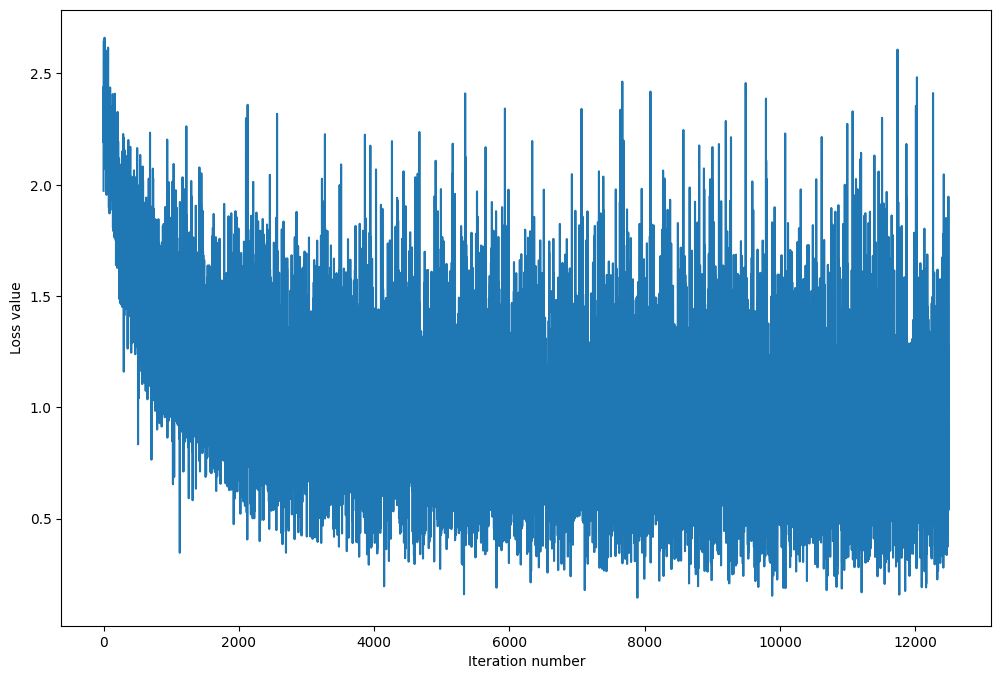

In [13]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### 4.4 Quantitative Results

We can analyze the accuracy of the predictions as follows. You should see around 69\% accuracies. We can finetune the hyperparameters to obtain better results.

*Disclaimer: This code piece is taken from PyTorch examples.*

In [14]:
correct = 0
total = 0

NewResNet18 = NewResNet18.to(device)

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = NewResNet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 69 %


### 4.5 Visual Results

We see that with just two epochs of training a single FC layer, we can get decent results.

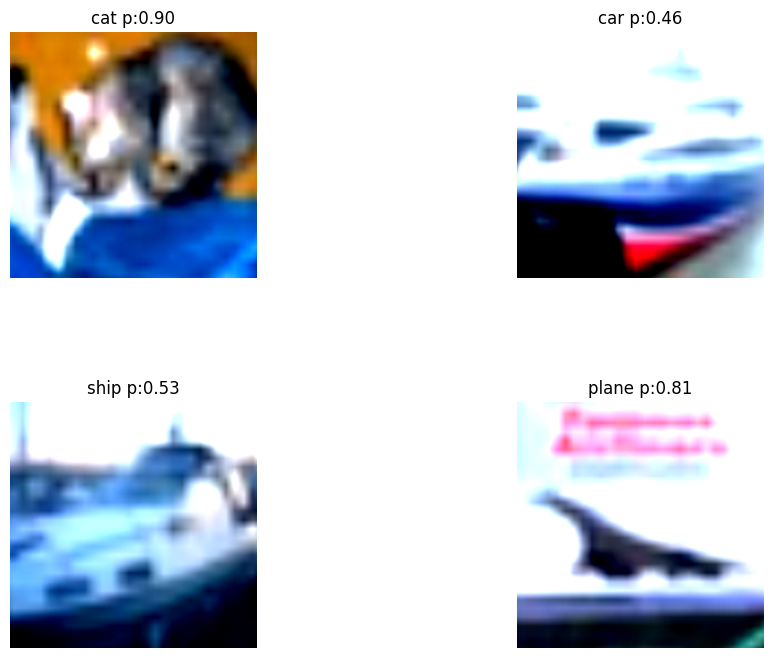

In [15]:
# Get a batch
dataiter = iter(testloader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)

# Get scores for classes on the batch
with torch.no_grad():
    output = NewResNet18(images)

# Convert them to probabilities (shape: batch_size x 1000)
probabilities = torch.nn.functional.softmax(output, dim=1)

# Show results on a 2x2 grid
S=2
for i in range(S):
  for j in range(S):
    X = images[i*S+j]
    X = np.transpose((X.to("cpu").numpy()/2+0.5), (1, 2, 0))
    top1_prob, top1_catid = torch.topk(probabilities[i*S+j], 1)
    title = "{} p:{:1.2f}".format(CIFAR10_classes[top1_catid], top1_prob.item())

    plt.subplot(S, S, i*S+j+1)
    plt.imshow(X)
    plt.axis('off')
    plt.title(title)
    plt.subplots_adjust(hspace = 0.5)
